# Imports/Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path

%matplotlib inline

dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

conn = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(os.getenv('DB_USER'),
                                                               os.getenv('DB_PASS'), 
                                                               os.getenv('DB_IP'), 
                                                               os.getenv('DB_PORT'), 
                                                               os.getenv('DB_NAME')))

# Download/Setup Data

In [2]:
dreampop_data = pd.read_sql("SELECT * FROM dreampop;", conn)
other_data = pd.read_sql("SELECT * FROM other;", conn)

In [3]:
#Combine data, drop non needed cols
data = dreampop_data.append(other_data, ignore_index=True)
data = data.drop(['index', 'type', 'uri', 'track_href', 'analysis_url'], axis=1)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre
0,0.482,0.866,7,-4.534,1,0.0293,0.000368,0.11600,0.247,0.372,147.994,5gEni4dmBqme8fyPcyWYiK,187364,4,Kate's Not Here - Day Wave & Lawrence Rothman ...,Lawrence Rothman,dreampop
1,0.543,0.498,9,-10.152,1,0.0678,0.692000,0.43200,0.078,0.815,113.392,0l4cR2AZ18MktMd0BU3zwh,241097,4,Tenderness,Jay Som,dreampop
2,0.644,0.756,7,-8.342,1,0.0273,0.567000,0.15800,0.151,0.802,120.030,04DdNbTmZAgHfNP6FdY3Sa,264955,4,Plum,Widowspeak,dreampop
3,0.508,0.798,1,-5.412,0,0.0259,0.256000,0.20200,0.701,0.481,153.950,22gjW0ccBALzqASrryR7Dw,213481,4,Opportunity,Kevin Krauter,dreampop
4,0.562,0.724,2,-6.787,1,0.0622,0.203000,0.00115,0.129,0.464,139.997,4kDqNIQiBwkqDs6jWWcHAM,166453,4,What Does It Mean To Me?,Oberhofer,dreampop


In [4]:
#Create genre ids
genres = list(data.groupby('genre').count().index)
genre_to_id = {}
id_to_genre = {}
for i, g in enumerate(genres):
    genre_to_id[g] = i
    genre_to_id[i] = g

In [5]:
#Map genres
data['genre_id'] = data['genre'].apply(lambda x: genre_to_id[x])
data['is_dreampop'] = data['genre'].apply(lambda x: True if x == 'dreampop' else False)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre,genre_id,is_dreampop
0,0.524,0.342,0,-14.608,1,0.0252,0.032000,0.826000,0.3270,0.3170,81.054,03G3AeWtkucC5Ug2zngbwD,310370,4,It's Alright With Me,Part Time,dreampop,28,True
1,0.414,0.426,1,-12.223,0,0.0351,0.251000,0.877000,0.0995,0.0394,158.044,6UUOkhXDWTqVYjzqNJ1F0x,187993,4,So High,Ghost Loft,dreampop,28,True
2,0.403,0.643,11,-6.172,0,0.0282,0.000106,0.212000,0.2410,0.1110,139.873,76jmXjmUePMiMJhH3O8W1Y,377280,4,Burning - Dubba Jonny Remix,Firetruck,dubstep,31,False
3,0.655,0.204,9,-14.161,1,0.0392,0.945000,0.000240,0.6890,0.3470,128.757,1R9LsIiEXCiDANJNFCxnGp,186000,4,Park Music,Scott James,dreampop,28,True
4,0.762,0.701,8,-3.541,1,0.0286,0.235000,0.000158,0.1230,0.7420,110.968,748mdHapucXQri7IAO8yFK,208867,4,Kiss Me More (feat. SZA),Doja Cat,dreampop,28,True


# Create train, test, validate sets

In [6]:
data_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X = data[data_cols].to_numpy()
y = data['is_dreampop'].to_numpy().astype(int)
X.shape, y.shape

((24248, 13), (24248,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((14548, 13), (4850, 13), (4850, 13), (14548,), (4850,), (4850,))

# Classifiers

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_lr.score(X_test, y_test)

0.5197938144329897

## Naïve Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB().fit(X_train, y_train)
clf_nb.score(X_test, y_test)

0.5426804123711341

## Stochastic Gradient Descent

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf_sgd.fit(X_train, y_train)
clf_sgd.score(X_test, y_test)

0.6812371134020618

## K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

0.5832989690721649

## Decision Tree

<ipython-input-12-7e60ad66b819>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


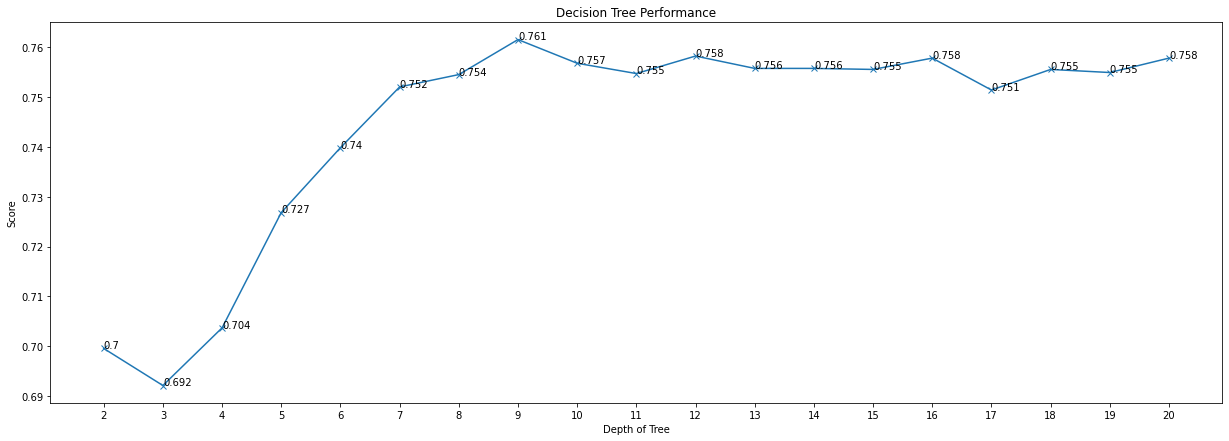

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

depths = list(range(2, 20 + 1))
scores = []
for d in depths:
    clf_dt = DecisionTreeClassifier(random_state=0, max_depth=d)
    clf_dt.fit(X_train, y_train)
    scores.append(clf_dt.score(X_test, y_test))

plt.figure(figsize=(21, 7))
plt.plot(depths, scores, '-x')
plt.xlabel('Depth of Tree')
plt.xticks(list(depths))
plt.ylabel('Score')
plt.title('Decision Tree Performance')
ax = plt.axes()
for i, v in enumerate(scores):
    ax.annotate(round(v, 3), (depths[i], scores[i]))
plt.show()

0.7614432989690721


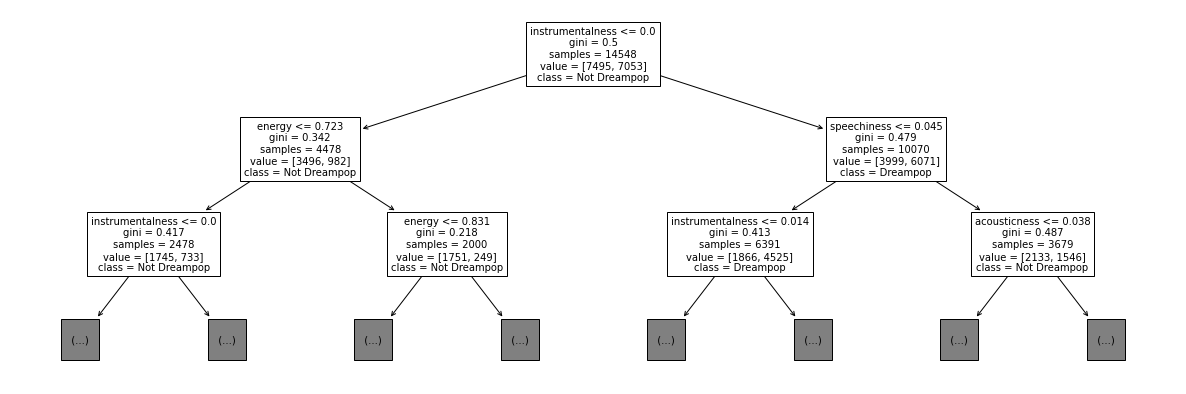

In [13]:
clf_dt = DecisionTreeClassifier(random_state=0, max_depth=scores.index(max(scores)) + 2)
clf_dt.fit(X_train, y_train)

plt.figure(figsize=(21, 7))
tree.plot_tree(clf_dt, feature_names=data_cols, class_names=['Not Dreampop', 'Dreampop'], max_depth=2)
clear_output()
print(clf_dt.score(X_test, y_test))

## Random Forest

<ipython-input-14-43b4ca638102>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


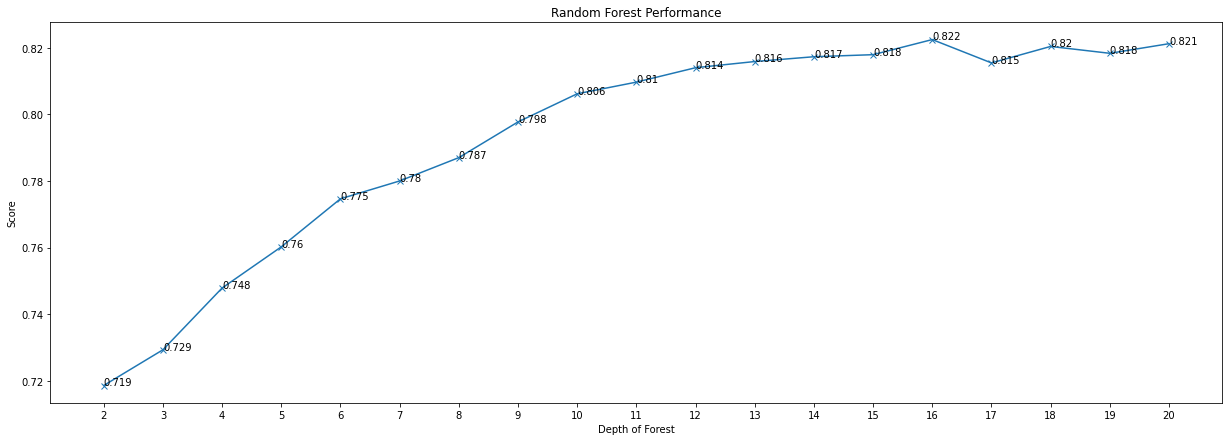

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

depths = list(range(2, 20 + 1))
scores = []
for d in depths:
    clf_rf = RandomForestClassifier(random_state=0, max_depth=d)
    clf_rf.fit(X_train, y_train)
    scores.append(clf_rf.score(X_test, y_test))

plt.figure(figsize=(21, 7))
plt.plot(depths, scores, '-x')
plt.xlabel('Depth of Forest')
plt.xticks(list(depths))
plt.ylabel('Score')
plt.title('Random Forest Performance')
ax = plt.axes()
for i, v in enumerate(scores):
    ax.annotate(round(v, 3), (depths[i], scores[i]))
plt.show()

In [15]:
clf_rf = RandomForestClassifier(max_depth=scores.index(max(scores)) + 2, random_state=0)
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.8224742268041237

## Support Vector Machine

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(X_train, y_train)
clf_svm.score(X_test, y_test)

0.777319587628866

# Cross Validation

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

models = [clf_lr, clf_nb, clf_sgd, clf_knn, clf_dt, clf_rf, clf_svm]
names = ['clf_lr', 'clf_nb', 'clf_sgd', 'clf_knn', 'clf_dt', 'clf_rf', 'clf_svm']
scores = [[] for _ in models]

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        scores[i].append(model.score(X_test, y_test))

TRAIN: [    0     1     2 ... 24245 24246 24247] TEST: [    6     9    10 ... 24235 24236 24243]
TRAIN: [    0     1     4 ... 24243 24244 24247] TEST: [    2     3     5 ... 24231 24245 24246]
TRAIN: [    0     1     2 ... 24245 24246 24247] TEST: [    4     8    11 ... 24232 24238 24240]
TRAIN: [    0     2     3 ... 24244 24245 24246] TEST: [    1    21    23 ... 24233 24239 24247]
TRAIN: [    1     2     3 ... 24245 24246 24247] TEST: [    0     7    14 ... 24241 24242 24244]


In [18]:
scores = [np.mean(score) for score in scores]
sorted(list(zip(names, scores)), key=lambda x: x[1], reverse=True)

[('clf_rf', 0.8245215231964078),
 ('clf_svm', 0.7727232610401125),
 ('clf_dt', 0.7612171199078139),
 ('clf_sgd', 0.6677657929257388),
 ('clf_knn', 0.5974514970670964),
 ('clf_nb', 0.5454878527403886),
 ('clf_lr', 0.5165783911232628)]

# Feature Importance

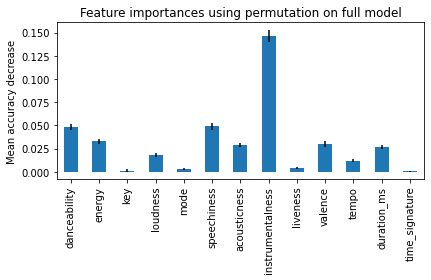

In [36]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importances_perm = result.importances_mean

forest_importances = pd.Series(result.importances_mean, index=data_cols)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [40]:
imp_perm = list(zip(data_cols, importances_perm))
imp_perm = sorted(imp_perm, key=lambda x: x[1], reverse=True)
imp_perm

[('instrumentalness', 0.1466487935656836),
 ('speechiness', 0.04897917096308514),
 ('danceability', 0.0482367498453289),
 ('energy', 0.03268715199010103),
 ('valence', 0.02986182718086201),
 ('acousticness', 0.02848009898948234),
 ('duration_ms', 0.02660342338626518),
 ('loudness', 0.018106826149721568),
 ('tempo', 0.01216745720767166),
 ('liveness', 0.004289544235924902),
 ('mode', 0.00294906166219836),
 ('key', 0.0012373685295936966),
 ('time_signature', 0.0003918333677046526)]